<h1><center> Goals and Discussion </center> </h1>

We implemented a diffusion model to generate images trained on the CIFAR-10 dataset. Diffusion models are a class of generative models which have achieved state of the art performance on standard image generation tests, and underly many recent advancements in generative modeling. In the context of image generation, diffusion models work by systematically adding noise to the training data through a Gaussian process. A neural network is then trained to predict the noise added to the image at each timestep, ultimately allowing images to be generated from a random sample of a standard Gaussian.

The CIFAR-10 dataset consists of 60,000 32x32 pixel RBG images across 10 classes, and we used various subsets of this dataset to train our model. We trained an unconditional model on a single class (cats) from the CIFAR-10 dataset, as well as a conditional model on multiple classes. See below for some sample generated images from our model.

In what follows, we will recount our goals from our revised proposal and discuss the progress we made towards these goals.

<h2> Essential Goals </h2>

Each bullet point below is one of the essential goals we submitted in our update

- **Essential Goal 1:** Our plan is to create the model from scratch following the implementation from Ho et al. We will be using the implementation from https://www.youtube.com/watch?v=a4Yfz2FxXiY as reference if we get stuck. One change we may make right away is to use a simpler architecture for the neural network, since U-Nets are expensive to train.

We successfully implemented the diffusion model from scratch, but ultimately appealed to a pre-built U-NET neural network as our denoising net. In particular, our code implements both algorithms 1 (training) and 2 (sampling) from Ho et al. The training algorithm presented in the paper is a simplification of a more general loss function (see equation (5) in loc. cit.) which we also implemented in code, although all of the experiments we will discuss in this report use the simplified loss function of the paper.

We organized our code in to three classes: the diffusion_process, the denoiser, and the diff_model.

The diffusion_process class takes as input the number of timesteps as well as the initial and final steps of the variance schedule. Using the inputs, the total variance schedule is generated by linearly interpolating between the initial and final variances using the specified number of timesteps. The diffusion process then contains two functions. Denoting by $q(x_{t}|x_{t-1})$ the Gaussian distributions defining the Gaussian process (determined by the variance schedule) the diffusion_process class contains a function 'forward_var' which computes the variance of the distribution $q(x_{t}|x_{0})$ from the variance schedule. The second function takes in an image and a number of timesteps, and adds noise to the image for the specified timesteps.

The denoiser class takes as input a neural network and uses the neural network to remove noise from images. In retrospect, this class should have been absorbed in the diff_model class which we discuss next.

The diff_model class organizes the utilities needed to compute the loss function (equation (5) in Ho et. al.), generate images (algorithm 2 in loc. cit.), and generate conditional samples (a simple variant of algorithm 2 in loc. cit.).


The U-NET neural network was taken from the github repository https://github.com/dome272/Diffusion-Models-pytorch, but we explored many variants of this architecture. These variants will be discussed in the 'desirable goals' section.


See the sample images below.



- **Essential Goal 2:** We will evaluate the performance of the model using this FID implementation: https://pytorch.org/ignite/generated/ignite.metrics.FID.html. 

We were successfully able to evaluate our diffusion models' performance using FID analysis. The implementation we used was from https://github.com/mseitzer/pytorch-fid, which is the code that the pytorch implementation was based on. Trained models were used to generate images, which were then compared to the test dataset to determine the FID score, where a lower score indicates that the distribution of generated images matches closely with the distribution of test images. All unconditional tests were done with the cat class.

We first determined the FID score between a set of images from the training data and a set of images from the test data. When comparing the FIDs of 500 images from each set, we discovered that the FID was relatively high, at **87**, when we would expect it to be low. We then increased the sample size from 500 to 1000, and found that the FID decreased to **49.838**. This substantial decrease agreed with our readings that FID is very dependent on the sample size. After some more testing, the FID decreased to 0.05 with a sample size of 10000 images, which was the size of our entire test set. Due to computing constraints for image generation, we decided to analyze all FID scores using a sample size of *1000 images*, comparing these scores to **49.838** as the optimal FID rather than 0. 

The following are the FID scores we obtained at a sample size of 1000 for various versions of diffusion models:
<table>
    <tr>
        <th>Model</th>
        <th>FID Score:</th>    
    </tr>
    <tr>
        <td>2xUD Half Channels</td>
        <td>114.710</td>
    </tr>
    <tr>
        <td>2xUD</td>
        <td>100.144</td>
    </tr>
    <tr>
        <td>Default UNet (3xBlocks)</td>
        <td>118.501</td>
    </tr>
    <tr>
        <td>UNet 3xBlocks with Cosine schedule</td>
        <td>115.949</td>
    </tr>
    <tr>
        <td>UNet 2xUD Cosine schedule</td>
        <td>97.275</td>
    </tr>
</table>

From the above results, we see that the architecture of the UNet does affect the FID scores, albeit in some interesting ways. The 2xUD halfchannels FID was larger than the 2xUD, which was expected as this UNet used half the number of channels as 2xUD, resulting in the worse FID score. On the other hand, it was interesting to not that the 3xBlocks model, which had an one more down and up layer than 2xUD did even worse than the halfchannel. A possible explanation could be that because the bottleneck resolution is not as restrictive, more information is able to get through. These three models all used a linear schedule when noising an image. We also tried using a cosine schedule, as this noises the image more gradually, allowing more information to be learned at later timesteps when the image has substantial noise. As expected, the FID results were better, with the 3xBlocks model and the 2xUD model improving by ~3 points.

All images used are saved in output/imagesBIG_FID


- **Essential Goal 3:** We are revising this goal to be the training of a DCGAN model on CIFAR-10 following https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html. We will keep both this and the diffusion model unconditional at first.

We successfully implemented the DCGAN model after modifying the architecture of the generator and discriminator. Since each conv/convtranspose either downscaled or upscaled the resolution by a factor of 2, we modified the layer structure and channel outputs to create the correct output shape. We also first did our data processing here by filtering the CIFAR-10 dataset to just the cats. After getting the default model working, we experimented with various improvements. The first was modification of layer structure: with fewer blocks, we thought that the number of channels at the different layers could be important, so we tried keeping more channels early on in the generator model before decreasing to the 3 RGB channels of the final output. We also implemented label smoothing, where Discriminator confidence is reduced by assigning 0.9 instead of 1. as a real label, and 0.1 instead of 0 as a fake label. Another method to decrease Discriminator overfitting that we implemented was to noise the inputs to the Discriminator.

We were able the successfully create our GAN models and calculate their FID scores which are as follows:


<table>
    <tr>
        <th>Model</th>
        <th>FID Score:</th>
    </tr>
    <tr>
        <td>1024 Epochs Smoothed GAN</td>
        <td>125.629</td>
    </tr>
    <tr>
        <td>1024 Epochs Default GAN</td>
        <td>109.09</td>
    </tr>
    <tr>
        <td>512 Epochs Default GAN</td>
        <td>113.311</td>
    </tr>
</table>

Here, we can see that the GAN models did very well compared to the diffusion models above. It is interesting to note that the smoothed GAN model did the worse out of all of them. As expected, the GAN model trained for double the number of epochs did much better with an FID of 109 vs 113. Our goal of seeing if diffusion models did better was achieved, as the 2xUD Models did better than the best GAN at both a linear and cosine noising schedule.

All images are saved in output/imagesBIG_FID

<h2><center> Selected Generated Images </center> </h2>

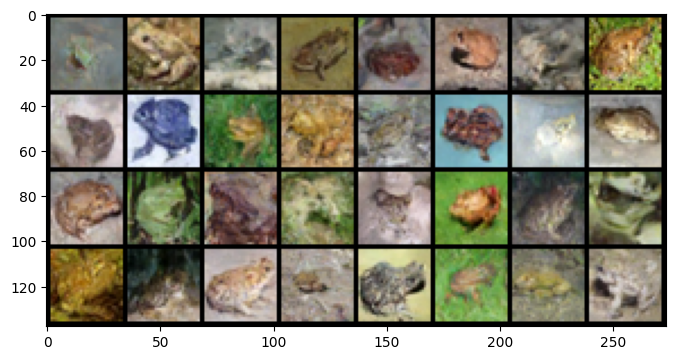

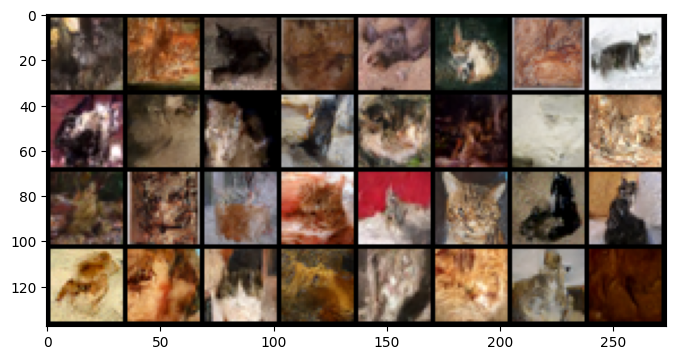

<h2> Desirable Goals </h2>

- **Desired Goal 1:** We will compare different neural network architectures such as U-Net and simpler architectures (e.g. a CNN).

We experimented with six distinct U-Net structures of varying sizes. The U-Net architecture involves a series of contracting layers, a bottleneck, and a series of expanding layers. The contracting layers consist of a stack of a convolutional layer, a self-attention layer, and a down-sampling which simultaneously shrinks the spatial dimensions of an input and incorporates the time-steps in the diffusion process. The contracting layers shrink the image size, and increases the number of channels similarly to a standard convolutional neural network, but with pooling operations replaced by downsampling. The expanding layers are similar stacks of three distinct layer types, but shrinks the number of channels to the usual three while expanding the image size, outputting an image at the end. The bottleneck consists of a series of convolutional layers.

- **Desired Goal 2:** We will experiment with hyperparameters such as noise schedule, number of timesteps, and width/size of NN layers to improve performance.

We performed experiments probing the effects of all of these hyperparameters.

The largest model we experimented with consisted of three contracting layers, three expanding layers, and a bottleneck with three layers. The total number of trainable parameters in this model was 23,332,729. The smallest model we worked with shrunk the number of contracting/expanding/bottleneck layers to two as well as decreasing the number of channels at each layer. This model had 3,062,531 trainable parameters, nearly eight times smaller than our largest model. The smallest models trained much faster (approximately 1000 epochs in 2 hours with a GPU) whereas the largest was much slower (approximately 1000 epochs in 7 hours with a GPU). 

Using the largest model, we compared the effect of timesteps by training a model with 500, 1000, and 1500 timesteps respectively, all for 500 epochs. Larger numbers of timesteps resulted in predictably slower train times, but surprisingly didn't appear to generate perceptibly higher quality images (see below for samples).

- **Desired Goal 3:** Our diffusion model will do conditional generation, following the paper example and reference implementation.

We successfully implemented class conditioning in our model. This involves incorporating a class embedding inside the U-Net structure, akin to the timestep embedding. Interestingly, training a conditional model on two classes (cats and frogs) seemed to produce more accurate images of cats than an unconditional model trained solely on cats.

- **Desired Goal 4:** We will compare our GAN against our diffusion model using FID score. The architecture of the GAN will follow the above pytorch tutorial, but we will add in class conditioning.

We decided to use embedding layers for implementing class conditioning after finding an example PyTorch-GAN that used them. However, we embed the class information differently and add it in as additional channels. Our reasoning was that it would not disrupt the RGB image channels and would instead be on separate channels as class information for the network to use. We accomplished this by tiling the Embedding output to match the 32x32 image shape so that it could be concatenated as additional channels. Classes are passed in as a class per input. We used this approach for both the Discriminator and Generator, and trained on a two class dataset of cats and frogs.

The models used were a smoothed GAN and a cosine schedule diffusion model with 3xblocks. The FIDs from models used to generate class-conditional images were also compared with the results as follows:

<table>
    <tr>
        <th>Class</th>
        <th>Model</th>
        <th>FID Score:</th>
    </tr>
    <tr>
        <td>Frog</td>
        <td>GAN</td>
        <td>181.748</td>
    </tr>
    <tr>
        <td>Cat</td>
        <td>GAN</td>
        <td>231.707</td>
    </tr>
    <tr>
        <td>Frog</td>
        <td>Diffusion</td>
        <td>70.517</td>
    </tr>
    <tr>
        <td>Cat</td>
        <td>Diffusion</td>
        <td>102.894</td>
    </tr>
</table>

In these results, we see that the GAN models do substantially worse than the diffusion models, indicating that our conditional implementation worked as we predicted. As mentioned previously, the cat conditional diffusion seem to do better than unconditional, with a FID of **102.894** versus an FID of **115.949**. Additionally, it seems that the class generated has a large effect on the FID, as the Frog diffusion model had a much better score than any other experiment we did. This does make sense, as the distribution of frog images seemed to have a low variance, whereas the cat training images would have cats in more different positions with varied backgrounds.

All images are saved in output/imagesCond_FID


Stretch Goals were abandoned so that we could analyze various forms of the diffusion and GAN models.

<h2><center> Samples from a Conditional Model </center> </h2>

The following samples were generated by the same conditional model.

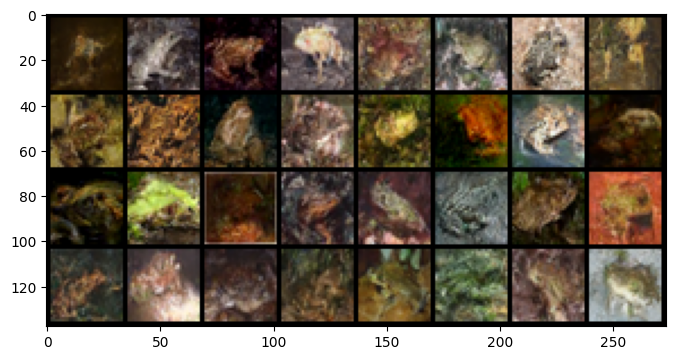
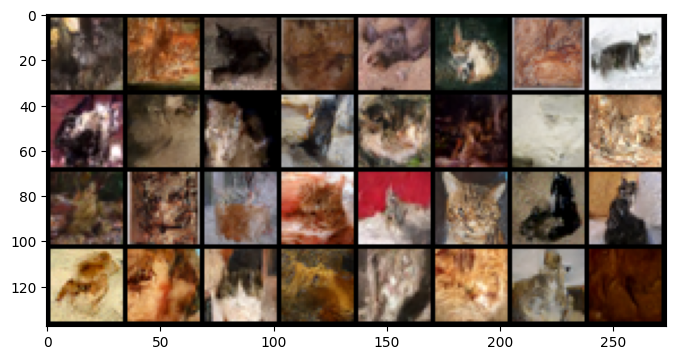

<h2><center> Frog Samples from Timestep Experiments </center></h2>

$T = 500$

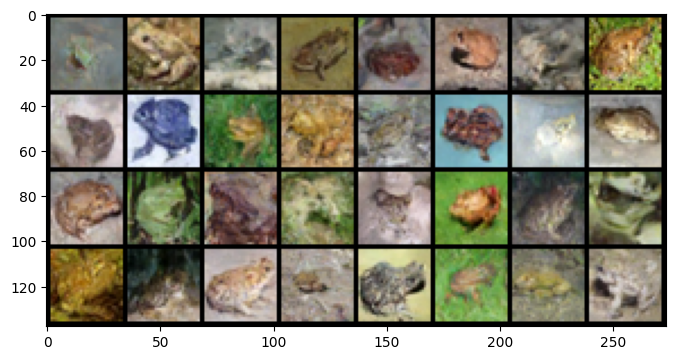

$T = 1000$

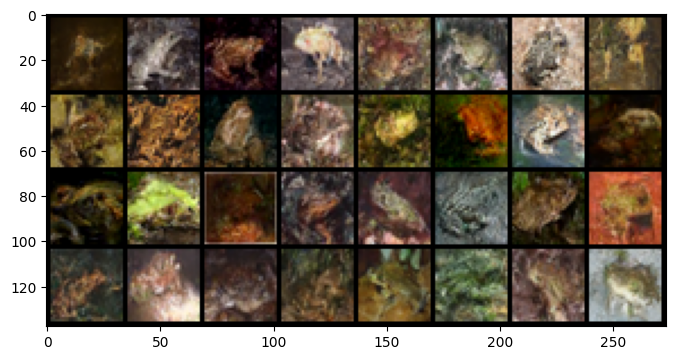

$T = 1500$

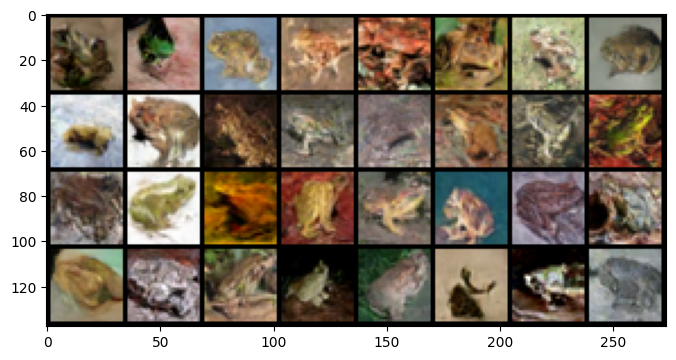


## Conditional GAN Samples

See report-images\conditional\1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G.pt-output.gif for an animation showing the progression of image quality over training steps. The first 4 rows of images were generated with a cat label while the remaining rows were generated with a frog label

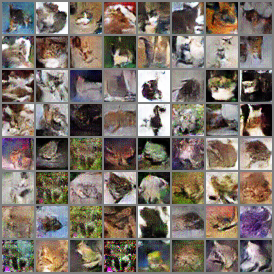

## Unconditional Diffusion Samples

### UNet with and without cosine noise scheduling

<!-- ![](report-images\unconditional\UNet-cosine.png) -->

<!-- ![](report-images\unconditional\UNet.png) -->

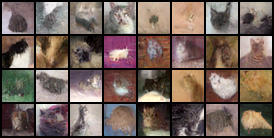

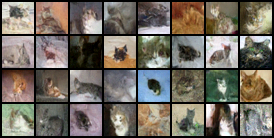

### UNet-2xUD with and without cosine noise scheduling

This model is similar to the above but with one less up and down sample block.

<!-- ![UNet_2xUD-cosine.png](report-images\unconditional\UNet_2xUD-cosine.png) -->

<img src="report-images\unconditional\UNet_2xUD-cosine.png"/>

<!-- ![UNet_2xUD.png](report-images\unconditional\UNet_2xUD.png) --

>


<img src="report-images\unconditional\UNet_2xUD.png"/>

### Default and modified DCGANs

Modified DCGAN had label smoothing as well as Discriminator input noising. Layer structure was also changed to keep more layers in the early stages of the generation before eventually reducing to the 3 output image channels

<!-- ![DCGAN.png](report-images\unconditional\DCGAN.png) -->

<img src="report-images\unconditional\DCGAN.png"/>



<!-- ![1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G.pt-image.png](report-images\unconditional\1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G.pt-image.png) -->

<img src="report-images\unconditional\1024ep_64nf_128nz_smoothed_noised_default-D_block2outngfx4-G.pt-image.png"/>

<h1><center> Code Documentation </center></h1>

- diffusion.py
    - Our main file containing various functions for the diffusion process, written from scratch following the DDPM paper by Ho. This creates the diff_model class that contains the denoising NN and diffusion process functions in order to both noise images (forward process) and generate denoised images (generative process).
- modules.py
    - Contains the models used for our diffusion, mainly based off the reference Diffusion Models U-Net implementation. We try different numbers of layers and different numbers of channels, as well as a simpler Conv-ConvTranspose model that we add time embedding to.
- conditional_diffusion.ipynb
    - Contains the main code to train our conditional model, using the components from diffusion.py and a conditional U-Net from the reference code as the denoiser NN.
- conditionalgan.ipynb
    - Modification of catgan that is class conditional by using an embedding layer and adding the resultant embedding output as additional channels to the discriminator and GAN.
- catdiffusion.ipynb
    - Unconditional model following our reference Diffusion Models code, mainly used to get baseline results and test improvements such as a cosine noise schedule or different architectures and hyperparameters prior to getting our own code working.
- catgan.ipynb: 
    - Notebook implementation of the Pytorch unconditional DCGAN tutorial, with modified CNN structures to handle the 32x32 CIFAR-10 cat images. Implements additional improvements such as changed layer structure, label smoothing, and noising discriminator inputs.
- cat_diffusion_model.ipynb
    - Contains the main code to train our unconditional model, using the components from diffusion.py and a various modifications of the U-Net from the reference Diffusion Models code.
- 1000FIDanalysis.ipynb
    - Contains the code that saves 1000 images from the cat train set, cat test set, generated images from 5 diffusion models (2xUD UNet, 2xUD UNet w/ half the number of channels, default UNet (3 up/down blocks), UNet 3xUD with cosine schedule, UNet 2xUD with cosine schedule), and 3 GAN models (1024 epochs smoothed GAN, 1024 epochs default GAN, 512 epochs default GAN). After saving, FID calculation is performed.
- ConditionalFID.ipynb
    - Contains the code that saves 1000 images from cat train, cat test, and generated images from a smoothed GAN model and a 3xUD cosine model, each of which generated images of class Frog or class Cat. Fid calculation was then performed.


<h1><center> Reflections </center></h1>

<h2>What was interesting?</h2>

One aspect of the paper that required significant unpacking and seemed highly relevant was their analysis of the loss function. Diffusion models are basically a very specific form of hierarchical variational autoencoders, and thus there is a very general form of loss function to train them, arising from the field of variational Bayesian inference. However, using the additional assumptions one incorporates into diffusion models, the authors drastically simplify the loss function. Ultimately, we train the neural network to predict the noise that was added at each timestep during the diffusion process, which then allows us to iteratively 'subtract' the noise from a noisy image. It was very enlightening to work through the process of taking a very general Bayesian setup and systematically incorporating simplifying hypotheses to arrive at a very conceptual approach to optimizing a diffusion model.

The lectures on CNNs, GANs, and VAEs were the most relevant. It was really interesting seeing the CNN architecture applied to GANs as it both used regular convolutions and a new concept of convolution transposes in order to upscale the resolution. Learning about adversarial training helped us intuitively understand concepts such as label smoothing and noising as ways to weaken the Discriminator to help the Generator work.

It was also interesting to see how susceptible the FID score was to small changes in how the code was run such as whether it was run on cpu or cuda. Additionally, the sample size had a large effect on FID score so all analysis was done with 1000 images

<h2> What was challenging? </h2>

Overall, trying to grasp the mathematical background behind the paper implementations were difficult. While the final simplified loss function of MSE between predicted noise and actual noise intuitively made sense, it wasn’t clear to us the derivation from the much more complex ELBO to the simplified loss function.

Attempting to use only the paper to implement a diffusion model was quite challenging. The first couple of weeks, we didn’t reference other existing implementations of diffusion models at all while building our model. There were many organizational choices that had to be made in this process, and in retrospect not all of our choices were optimal. In addition to organizing the code, once we had an initial draft, the amount of debugging required to get the model to work was pretty significant, and ultimately there was one conceptual flaw preventing our first attempt at replicating the paper from achieving high-quality results: in the training loop, the random time-step sampling should be performed in batches, but initially we sampled a single timestep for the entire batch. So while the diffusion model would train, it was slower and less accurate until this was fixed. We only addressed this problem after reading the reference code.

<h2> What's left to do? </h2>

With more time and compute resources, we would first like to replicate the original paper results completely. Although we followed the same algorithms, our FID scores and qualitative image quality were far from their results, and we would like to do a larger search of hyperparameters to find good results. With more time, we’d also want to pursue our stretch goals to understand the generative process better and to explore ways to tune the model in a computationally efficient way.

Other generative models (e.g. variational auto-encoders, GANs, etc…) can often be used for the purposes of representation learning. In particular, the latent variables used in these other models often correspond to structurally meaningful properties of the training data (and in fact can even be trained to do so). Diffusion models on the other hand impose much stricter control over the form of the latent variables: they are merely noisy versions of training data. While this control yields impressive generative results, it doesn’t yield helpful representations of the training data. One possible offshoot of this project would be to import diffusion-like techniques into the study of representation learning by combining a diffusion model with a variational auto-encoder structure. Namely, we could perform a diffusion process on the latent variable inside a standard variational autoencoder, training the model to simultaneously generate images (using the autoencoder structure) and reconstruct the latent variables from noisy versions (by diffusing the latent variables through a Gaussian process). It’s unclear what loss function to use in this setup to encourage the model to learn useful representations, but it would be fun to experiment with and provide an opportunity to dive deeper into the theoretical underpinnings of these models.
